<a href="https://colab.research.google.com/github/Zero-Rae/QCES123/blob/main/project1_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project1_dedalus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solving the diffusion equation with Dedalus

**Overview:** This notebook solves the diffusion equation using a spectral method and provides an introduction to Dedalus.

**About Dedalus:** [Dedalus](http://dedalus-project.org) is an open-source Python package for solving partial differential equations (PDEs) using spectral methods.
These methods provide highly accurate numerical solutions for PDEs with smooth solutions in simple domains like boxes and spheres.
Dedalus implements modern parallel algorithms utilizing sparse polynomial bases, but all with an easy-to-use symbolic interface.
The code is being used in a wide range of fields, often for problems involving fluid dynamics.

This script is based in part on the Introduction to Dedalus by [Keaton Burns](http://keaton-burns.com)

The student exercise starts in [Section 5](#student_investigation)

# 1. Setup

First, we need to install Dedalus.  If you are running Python on your local computer, follow the install instructions in the [Dedalus Docs](https://dedalus-project.readthedocs.io/en/latest/pages/installation.html) to install Dedalus locally on your computer.

The cell below checks to see if Dedalus is installed.  After installing Dedalus, run the cell below to verify that Dedalus is installed correctly.

If you are using Google Colab, the cell below will automatically install Dedalus.

This cell checks if Dedalus is installed and performs some other basic setup. This will take some time the first time you run it.

Once you have Dedalus installed, you won't need to run this cell again.

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

At the start of each Python script, we need to import the packages that we will use.  The cell below imports the packages that will be needed here, namely numpy, matplotlib (for plotting) and dedalus. Note that we assign aliases for numpy, matplotlib, and dedlaus. Run this cell before running any of the cells below.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

## 2. Dedalus basics

Dedalus solves PDEs using spectral methods.  Dedalus requires us to specify the spatial coordinates, the `distributor`, and the spectral bases, which are explained below.

### Coordinates

We can use a variety of coordinate systems in Dedalus. For example, for multi-dimensional problems, we can use Cartesian coordinates, polar coordinates, spherical coordinates, etc. Here, we will set up a 1D problem using the Dedalus `Coordinate` class. We will see other examples in future projects.
For more details on other problem types, included distributed parallel simulations, see the official [Dedalus Tutorial 1](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_1.html).

Let's create a coordinate object representing our 1D coordinate, which here we will call `x`:

In [3]:
xcoord = dedalus.Coordinate('x')

### Distributors

Dedalus uses MPI (Message Passing Interface) for allow parallel computation on distributed memory systems. There are various options for how to distribute the computation amongst the processes. In Dedalus this is done by an object called a `Distributor`. Here, we will run not run in paralle, but Dedalus still requies us to create a `Distributor` object. You don't need to worry about this now, we will discuss it further in later projects.

The line below creates a distributor for our x coordinate for a problem with real variables.

In [4]:
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization

### Spectral basis

Dedalus decomposes the PDE that we are solving using a spectral basis. Dedalus has the ability to use different basis functions for this decomposition, and this gives Dedalus remarkable flexibility. For example, `RealFourier` provides a Fouier basis (sine and cosine functions) can be used for problems that are periodic (cyclic) in physical space. The `Chebyshev` basis allows boundary conditions to be set on a finite interval. The `SphereBasis` allows us to solve problems on a sphere.

The line below creates a Fourier basis for a real-valued system with a domain size of Lx=10 and with Nx=1024 gridpoints in physical space.

In [5]:
# Set some parameters
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
x_start=-1; x_end=1 # The starting and ending bounds on x

# Construct a Fourier basis
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))

### Grids

Each basis has a corresponding grid in physical space that can be used for tasks like initializing and plotting fields.

The line below creates a grid for the x coordinate.


In [6]:
x = dist.local_grid(x_basis)

### Fields

`Field` objects in Dedalus represent scalar-valued fields defined over a set of bases (or a "domain").
For multidimensional problems, vector and tensor valued fields can also be constructed using the `VectorField` and `TensorField` clases.

Let's construct a field called `c` (for concentration) using our 1D basis:

In [7]:
c = dist.Field(name='c', bases=x_basis)

Field objects have internal methods for transforming their data between grid (`'g'`) and coefficeint (`'c'`) space representations.
The field's values can be assigned and retrieved by indexing a field with these strings.

Let's set the grid-space values of our field, `c`, to be a Gaussian function of `x`. This is how we set the initial condition for the initial value problem that we will solve below.

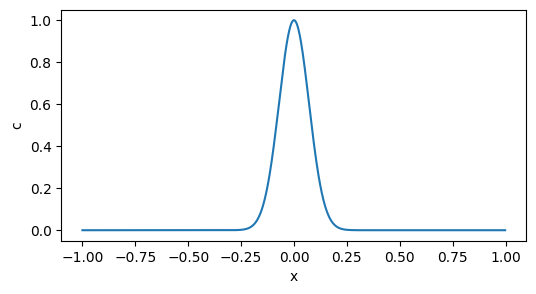

In [8]:
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

plt.figure(figsize=(6, 3)) # Set the size of the figure
plt.plot(x, c['g']) # Plot the "grid-space" initial conditions
plt.xlabel('x'); plt.ylabel("c"); # Set the axis labels

As a bit of an aside, we can find the coefficients of the spectral representation of a field using ['c'] instead of ['g'].
This triggers an in-place spectral (in this case Fourier) transform of the field's data.
For the `RealFourier` basis, the coefficients are the interleaved real-valued coefficients of the cosine and (negative) sine coefficients.
For very large problems transforming between grid and coefficient space will be time-consuming, so you will want to limit the number of times that this is done.

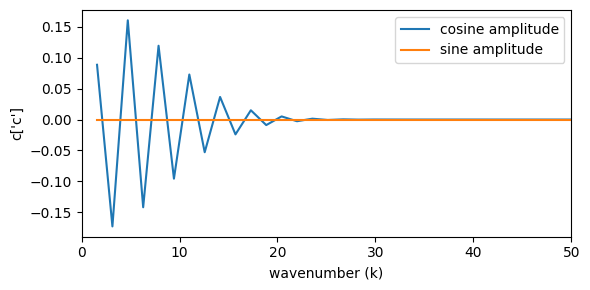

In [ ]:
k = np.pi * np.arange(1, Nx/2+1) / (x_end - x_start) # Create an array of wavenumbers, k(i)=i*pi/Lx
plt.figure(figsize=(6, 3))
plt.plot(k, c['c'][0::2], label='cosine amplitude')
plt.plot(k, -c['c'][1::2], label='sine amplitude')
plt.xlabel('wavenumber (k)')
plt.ylabel("c['c']")
plt.xlim(0, 50)
plt.legend()
plt.tight_layout()

## 3. Problems and Solvers

Dedalus uses Problem and Solver classes to specify the problem and the methods that will be used to solve it. Here, we will set up the diffusion equation and solve it using the Crank-Nicolson timestepping method.

For more details on other problem types, see [Dedalus Tutorial 3](https://dedalus-project.readthedocs.io/en/latest/notebooks/dedalus_tutorial_2.html).

### Problems

Dedalus standardizes the formulation of all initial value problems by taking systems of symbolically specified equations and boundary conditions specified in the following generic form:

$$\mathcal{M} \cdot \partial_t \mathcal{X} + \mathcal{L} \cdot \mathcal{X} = \mathcal{F}(\mathcal{X}, t)$$

where $\mathcal{M}$ and $\mathcal{L}$ are matrices of linear differential operators, $\mathcal{X}$ is a state vector of the unknown fields, $\mathcal{F}$ is a vector of general nonlinear expressions.

The left-hand side (LHS) of the equations must be first-order in temporal derivatives and linear in the problem variables.
The right-hand side (RHS) of the equations may contain nonlinear and time-dependent terms, but no temporal derivatives.

When using a mixed implicit/explicit timestepping scheme, Dedalus will apply the implicit method to the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit method to the $\mathcal{F}(\mathcal{X}, t)$ term.

To create a problem object, we provide a list of the variables to be solved for. In this case, this is just `c`.

Equations can then be entered as pairs of operator expressions like `(LHS, RHS)` or as strings like `"LHS = RHS"`.

Here, let's set up the diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = 0$$

Note that we put the term with the second derivative on the left hand side of the equation so that it will be time-stepped implicitly.

In [ ]:
# Parameters
kappa = 0.001

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa*dx(dx(c)) = 0"); # Write out the equation to be solved


### 3.2 Solvers

Now, we need to specify the solver.  For IVPs, we specify a timestepping method when building the solver. Below we select the `CNAB1` timestepper which uses Crank-Nicolson for the $\mathcal{L}\cdot \mathcal{X}$ term and the explicit first order Adams-Bashforth method for the right hand side term (but in this case the RHS is zero).

In [ ]:
timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-12-27 06:26:12,295 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


Next, we need to specify a condition for the simulation to end. This can be a set number of iterations (set using `solver.stop_iteration`), a stopping time in simulation time units (set using `solver.stop_sim_time`, or a maximum wall clock time in seconds (set using `solver.stop_wall_time`).



In [ ]:
solver.stop_sim_time = 10 # Stop at 10 simulation time units

IVPs are iterated using the `solver.step` method with a provided timestep.
The logic controlling the main-loop of a Dedalus IVP simulation occurs explicitly in the simulation script.
The `solver.proceed` property will change from `True` to `False` once any of the specified stopping criteria have been met.
Let's timestep our problem until the halting condition is reached, copying the grid values of `u` every few iterations.
This should take just a few seconds to run.

In [ ]:
# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    # save the values of c and t
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

INFO:solvers:Simulation stop time reached.


2024-12-27 06:26:17,315 solvers 0/1 INFO :: Simulation stop time reached.


Now we can make a space-time plot of the solution:

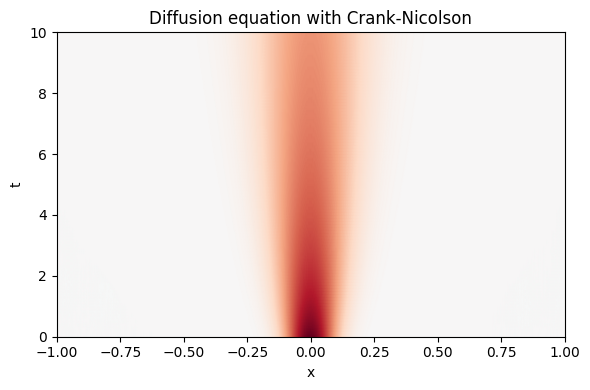

In [ ]:
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title(f'Diffusion equation with Crank-Nicolson')
plt.tight_layout()

## 4. Forced diffusion equation

Dedalus is extremely flexible, which will make it very useful throughout the QCES computational projects. For example, it is relatively straightforward to change the equation that we are solving.

In order to introduce functions into the equations that Dedalus solves, we need to define a new operator.  For example, the following code defines the function $sin(x)$ on our grid:

In [ ]:
# Create an operator that applies a function to the variable on a grid
sin_x = dist.Field(bases=x_basis)
sin_x['g'] = np.sin(x)

The code below uses Dedlaus to solve the forced diffusion equation:

$$\partial_t c - \kappa \partial_x^2 c = cos(\pi x / Lx)$$

with the same Gaussian initial condition as before. This example also shows what a complete Dedalus script looks like.

DEBUG:distributor:Mesh: []
DEBUG:problems:Adding equation 0
DEBUG:problems:  LHS: dt(c) + -1*0.001*dx(dx(c))
DEBUG:problems:  RHS: <Field 139475591564784>
DEBUG:problems:  condition: True
DEBUG:problems:  M: c
DEBUG:problems:  L: -1*0.001*dx(dx(c))
DEBUG:problems:  F: <Field 139475591564784>
DEBUG:solvers:Beginning IVP instantiation
INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


2024-12-28 01:00:52,751 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.7e+01/s


DEBUG:solvers:Finished IVP instantiation
DEBUG:transforms:Building FFTW FFT plan for (dtype, gshape, axis) = (<class 'numpy.float64'>, (1024,), 0)
INFO:__main__:Iteration=500, Time=2.500000e+02, dt=5.000000e-01


2024-12-28 01:00:52,941 __main__ 0/1 INFO :: Iteration=500, Time=2.500000e+02, dt=5.000000e-01


INFO:__main__:Iteration=1000, Time=5.000000e+02, dt=5.000000e-01


2024-12-28 01:00:53,136 __main__ 0/1 INFO :: Iteration=1000, Time=5.000000e+02, dt=5.000000e-01


INFO:__main__:Iteration=1500, Time=7.500000e+02, dt=5.000000e-01


2024-12-28 01:00:53,355 __main__ 0/1 INFO :: Iteration=1500, Time=7.500000e+02, dt=5.000000e-01


INFO:__main__:Iteration=2000, Time=1.000000e+03, dt=5.000000e-01


2024-12-28 01:00:53,531 __main__ 0/1 INFO :: Iteration=2000, Time=1.000000e+03, dt=5.000000e-01


INFO:__main__:Iteration=2500, Time=1.250000e+03, dt=5.000000e-01


2024-12-28 01:00:53,710 __main__ 0/1 INFO :: Iteration=2500, Time=1.250000e+03, dt=5.000000e-01


INFO:__main__:Iteration=3000, Time=1.500000e+03, dt=5.000000e-01


2024-12-28 01:00:53,894 __main__ 0/1 INFO :: Iteration=3000, Time=1.500000e+03, dt=5.000000e-01


INFO:__main__:Steady-state reached at time 1586.0


2024-12-28 01:00:53,971 __main__ 0/1 INFO :: Steady-state reached at time 1586.0
[array([1.91516960e-174, 9.12283218e-174, 4.33238229e-173, ...,
       2.05115507e-172, 4.33238229e-173, 9.12283218e-174]), array([-0.49969176, -0.49968236, -0.49965414, ..., -0.49960711,
       -0.49965414, -0.49968236]), array([-0.99876744, -0.99874864, -0.99869223, ..., -0.99859823,
       -0.99869223, -0.99874864]), array([-1.49722778, -1.4971996 , -1.49711505, ..., -1.49697413,
       -1.49711505, -1.4971996 ]), array([-1.99507356, -1.995036  , -1.99492333, ..., -1.99473556,
       -1.99492333, -1.995036  ]), array([-2.49230552, -2.4922586 , -2.49211785, ..., -2.49188327,
       -2.49211785, -2.4922586 ]), array([-2.98892442, -2.98886815, -2.98869936, ..., -2.98841804,
       -2.98869936, -2.98886815]), array([-3.48493102, -3.48486542, -3.48466861, ..., -3.48434061,
       -3.48466861, -3.48486542]), array([-3.98032607, -3.98025114, -3.98002636, ..., -3.97965173,
       -3.98002636, -3.98025114]), arr

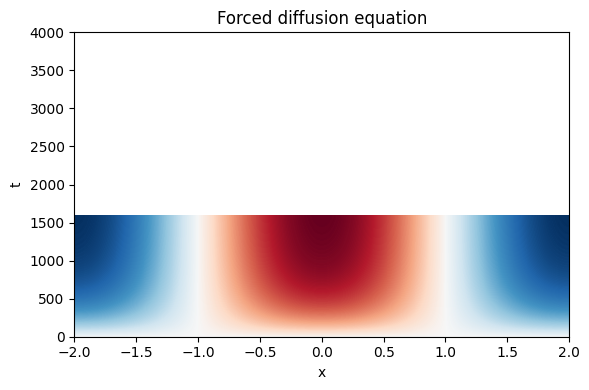

In [3]:
# Load the required packages (these were loaded above and are inluded here for completeness)
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# This script solves the forced diffusion equation with Dedlaus

# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx; x_end=Lx # The starting and ending bounds on x
kappa = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 4000 # Stop at 10 simulation time units

# Main loop
timestep = 0.5
c.change_scales(1)
tolerance = 1e-2  # Steady-state tolerance
c.change_scales(1)
c_save = [np.copy(c['g'])]
t_save = [solver.sim_time]

while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0:  # Print progress
        logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))

    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

    # Check for steady state
    if len(c_save) > 1:
        diff = np.max(np.abs(c_save[-1] - c_save[-2]))
        if diff < tolerance:
            logger.info(f'Steady-state reached at time {solver.sim_time}')
            break
print(c_save)
# Plot
plt.figure(figsize=(6, 4))
plt.pcolormesh(x.ravel(), np.array(t_save), np.array(c_save), cmap='RdBu_r', shading='gouraud', rasterized=True)#, clim=(-1, 1))
plt.xlim(x_start, x_end)
plt.ylim(0, solver.stop_sim_time)
plt.xlabel('x')
plt.ylabel('t')
plt.title('Forced diffusion equation')
plt.tight_layout()

## 5. Student investigation
<a id='student_investigation'></a>

### 5.1 Steady-state solution to the forced diffusion equation

For the forced diffusion equation described in section 4, using dimensional analysis, estimate the time needed to reach a steady-state solution. Test this scaling, and discuss your results below. Run the code above for a sufficient time to achieve a steady-state solution. Plot $c$ at the end of this simulation, and compare it with the exact steady-state solution to the forced diffusion equation.

Students should comment on the timescale needed to transition from the initial condition to the forced solution, and comment on the diffusive and forcing timescales.

The forced diffusion equation is:

$$\partial_t c - \kappa \partial_x^2 c = cos(\pi x / Lx)$$

**1. Dimensional analysis for the time and test**

Scaling analysis: Let
$$
c = c^* \times C, \quad
t = t^* \times T, \quad
\kappa = \kappa^* \times K, \quad
x = x^* \times L,
$$

where $c^*$, $t^*$, $\kappa^*$, and $x^*$ are dimensionless numbers and $C$, $T$, $K$, and $L$ are characteristic scales.
Substituting those into the forced diffusion equation, we have

$$
\frac{C}{T} \sim K \times \frac{C}{L^2}.
$$
Thus,
$$
T \sim \frac{L^2}{K}.
$$


Estimate the time needed to reach a steady-state solution:$$\tau \sim \frac{L_x^2}{\kappa},$$ with $L_x= 2$ and $\kappa=0.001$, then the estimate time to achieve steady state is $t \approx 4000$.

In the Dedalus code above, I used a concentration tolerance of $10^{-6}$ to find the steady-state time. From multiple tests with different timesteps, I found that the steady-state time is approximately within the range of $[1500,2500]$. This difference between simulation and prediction might be because the timestep cannot be set too small (as the code running cannot support excessively small timesteps), leading to less accurate solutions. It could also be due to the chosen tolerance. However, the results at t = 4000 have already reached the steady state. Furthermore, I plot the concentration time-series at x=0 below, which indicates a steady state at $t=4000$.

**2. Solution for the steady-state solution**

For steady state solution, $\partial_t c = 0$, which gives:

$
-\kappa \frac{\partial^2 c_s}{\partial x^2} = \cos\left(\frac{\pi x}{L_x}\right),
$

Integrate the equation:

$$
-\kappa \frac{\partial c_s}{\partial x} = \int \cos\left(\frac{\pi x}{L_x}\right) dx = \frac{L_x}{\pi} \sin\left(\frac{\pi x}{L_x}\right) + C_1,
$$

Integrate again:


$$
c_s(x) = \int \left(-\frac{1}{\kappa} \cdot \frac{L_x}{\pi} \sin\left(\frac{\pi x}{L_x}\right) + C_1\right) dx
= \frac{1}{\kappa} \cdot \frac{L_x^2}{\pi^2} \cos\left(\frac{\pi x}{L_x}\right) + C_1 x + C_2,
$$

where $C_1$ and $C_2$ are constants.

By boundary conditions: $$c_s(-L_x) = c_s(L_x)$$ $$\frac{\partial c_s}{\partial x}(-L_x) = \frac{\partial c_s}{\partial x}(L_x),$$

we have $C_1 = 0$.

Finally, the average constraint $\int_{-L_x}^{L_x} c_s(x) dx = 0$ implies:

$$
\int_{-L_x}^{L_x} c_s(x) dx = \int_{-L_x}^{L_x} \frac{1}{\kappa} \cdot \frac{L_x^2}{\pi^2} \cos\left(\frac{\pi x}{L_x}\right) dx + \int_{-L_x}^{L_x} C_2 dx=0.
$$

The first term integrates to zero due to the symmetry of $\cos(\pi x / L_x)$ over $[-L_x, L_x]$. Therefore, $C_2 = 0$.

Thus, the final steady-state solution is:

$$
c_s(x) = \frac{L_x^2}{\kappa \pi^2} \cos\left(\frac{\pi x}{L_x}\right).
$$




**4. Diffusive and forcing timescales**

Initially, diffusion dominates as it works to smooth out the sharp gradients in the initial condition.Over time, the forcing term gradually establishes a periodic steady-state solution. As for the timescale, the forcing term alters the spatial distribution of the steady state and drives the system toward a periodic steady-state response, but since the forcing term is time-independent and its range is fixed within the interval [-1, 1], its direct impact on the timescale is minimal. Therefore, the system primarily balances the initial condition and the forcing term through diffusion, and $t_{steady}\sim t_{diffusion}.$





INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-12-28 00:16:04,323 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:__main__:Iteration=500, Time=5.000000e+01, dt=1.000000e-01


2024-12-28 00:16:04,836 __main__ 0/1 INFO :: Iteration=500, Time=5.000000e+01, dt=1.000000e-01


INFO:__main__:Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


2024-12-28 00:16:05,024 __main__ 0/1 INFO :: Iteration=1000, Time=1.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


2024-12-28 00:16:05,198 __main__ 0/1 INFO :: Iteration=1500, Time=1.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


2024-12-28 00:16:05,424 __main__ 0/1 INFO :: Iteration=2000, Time=2.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


2024-12-28 00:16:05,598 __main__ 0/1 INFO :: Iteration=2500, Time=2.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


2024-12-28 00:16:05,806 __main__ 0/1 INFO :: Iteration=3000, Time=3.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


2024-12-28 00:16:05,990 __main__ 0/1 INFO :: Iteration=3500, Time=3.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


2024-12-28 00:16:06,169 __main__ 0/1 INFO :: Iteration=4000, Time=4.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


2024-12-28 00:16:06,369 __main__ 0/1 INFO :: Iteration=4500, Time=4.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


2024-12-28 00:16:06,560 __main__ 0/1 INFO :: Iteration=5000, Time=5.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


2024-12-28 00:16:06,772 __main__ 0/1 INFO :: Iteration=5500, Time=5.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


2024-12-28 00:16:06,951 __main__ 0/1 INFO :: Iteration=6000, Time=6.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


2024-12-28 00:16:07,136 __main__ 0/1 INFO :: Iteration=6500, Time=6.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


2024-12-28 00:16:07,337 __main__ 0/1 INFO :: Iteration=7000, Time=7.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


2024-12-28 00:16:07,521 __main__ 0/1 INFO :: Iteration=7500, Time=7.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


2024-12-28 00:16:07,697 __main__ 0/1 INFO :: Iteration=8000, Time=8.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


2024-12-28 00:16:07,881 __main__ 0/1 INFO :: Iteration=8500, Time=8.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


2024-12-28 00:16:08,059 __main__ 0/1 INFO :: Iteration=9000, Time=9.000000e+02, dt=1.000000e-01


INFO:__main__:Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


2024-12-28 00:16:08,231 __main__ 0/1 INFO :: Iteration=9500, Time=9.500000e+02, dt=1.000000e-01


INFO:__main__:Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


2024-12-28 00:16:08,417 __main__ 0/1 INFO :: Iteration=10000, Time=1.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


2024-12-28 00:16:08,583 __main__ 0/1 INFO :: Iteration=10500, Time=1.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


2024-12-28 00:16:08,767 __main__ 0/1 INFO :: Iteration=11000, Time=1.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


2024-12-28 00:16:08,961 __main__ 0/1 INFO :: Iteration=11500, Time=1.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


2024-12-28 00:16:09,133 __main__ 0/1 INFO :: Iteration=12000, Time=1.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


2024-12-28 00:16:09,339 __main__ 0/1 INFO :: Iteration=12500, Time=1.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


2024-12-28 00:16:09,517 __main__ 0/1 INFO :: Iteration=13000, Time=1.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


2024-12-28 00:16:09,695 __main__ 0/1 INFO :: Iteration=13500, Time=1.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


2024-12-28 00:16:09,881 __main__ 0/1 INFO :: Iteration=14000, Time=1.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


2024-12-28 00:16:10,066 __main__ 0/1 INFO :: Iteration=14500, Time=1.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


2024-12-28 00:16:10,254 __main__ 0/1 INFO :: Iteration=15000, Time=1.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


2024-12-28 00:16:10,494 __main__ 0/1 INFO :: Iteration=15500, Time=1.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


2024-12-28 00:16:10,781 __main__ 0/1 INFO :: Iteration=16000, Time=1.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


2024-12-28 00:16:11,069 __main__ 0/1 INFO :: Iteration=16500, Time=1.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


2024-12-28 00:16:11,337 __main__ 0/1 INFO :: Iteration=17000, Time=1.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


2024-12-28 00:16:11,579 __main__ 0/1 INFO :: Iteration=17500, Time=1.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


2024-12-28 00:16:11,829 __main__ 0/1 INFO :: Iteration=18000, Time=1.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


2024-12-28 00:16:12,090 __main__ 0/1 INFO :: Iteration=18500, Time=1.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


2024-12-28 00:16:12,358 __main__ 0/1 INFO :: Iteration=19000, Time=1.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


2024-12-28 00:16:12,638 __main__ 0/1 INFO :: Iteration=19500, Time=1.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


2024-12-28 00:16:12,903 __main__ 0/1 INFO :: Iteration=20000, Time=2.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


2024-12-28 00:16:13,194 __main__ 0/1 INFO :: Iteration=20500, Time=2.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


2024-12-28 00:16:13,488 __main__ 0/1 INFO :: Iteration=21000, Time=2.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


2024-12-28 00:16:13,778 __main__ 0/1 INFO :: Iteration=21500, Time=2.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


2024-12-28 00:16:14,071 __main__ 0/1 INFO :: Iteration=22000, Time=2.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


2024-12-28 00:16:14,360 __main__ 0/1 INFO :: Iteration=22500, Time=2.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


2024-12-28 00:16:14,545 __main__ 0/1 INFO :: Iteration=23000, Time=2.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


2024-12-28 00:16:14,719 __main__ 0/1 INFO :: Iteration=23500, Time=2.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


2024-12-28 00:16:14,897 __main__ 0/1 INFO :: Iteration=24000, Time=2.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


2024-12-28 00:16:15,080 __main__ 0/1 INFO :: Iteration=24500, Time=2.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


2024-12-28 00:16:15,284 __main__ 0/1 INFO :: Iteration=25000, Time=2.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


2024-12-28 00:16:15,478 __main__ 0/1 INFO :: Iteration=25500, Time=2.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


2024-12-28 00:16:15,689 __main__ 0/1 INFO :: Iteration=26000, Time=2.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


2024-12-28 00:16:15,902 __main__ 0/1 INFO :: Iteration=26500, Time=2.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


2024-12-28 00:16:16,081 __main__ 0/1 INFO :: Iteration=27000, Time=2.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


2024-12-28 00:16:16,299 __main__ 0/1 INFO :: Iteration=27500, Time=2.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


2024-12-28 00:16:16,477 __main__ 0/1 INFO :: Iteration=28000, Time=2.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


2024-12-28 00:16:16,663 __main__ 0/1 INFO :: Iteration=28500, Time=2.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


2024-12-28 00:16:16,838 __main__ 0/1 INFO :: Iteration=29000, Time=2.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


2024-12-28 00:16:17,012 __main__ 0/1 INFO :: Iteration=29500, Time=2.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


2024-12-28 00:16:17,204 __main__ 0/1 INFO :: Iteration=30000, Time=3.000000e+03, dt=1.000000e-01


INFO:__main__:Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


2024-12-28 00:16:17,414 __main__ 0/1 INFO :: Iteration=30500, Time=3.050000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


2024-12-28 00:16:17,597 __main__ 0/1 INFO :: Iteration=31000, Time=3.100000e+03, dt=1.000000e-01


INFO:__main__:Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


2024-12-28 00:16:17,775 __main__ 0/1 INFO :: Iteration=31500, Time=3.150000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


2024-12-28 00:16:17,955 __main__ 0/1 INFO :: Iteration=32000, Time=3.200000e+03, dt=1.000000e-01


INFO:__main__:Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


2024-12-28 00:16:18,142 __main__ 0/1 INFO :: Iteration=32500, Time=3.250000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


2024-12-28 00:16:18,360 __main__ 0/1 INFO :: Iteration=33000, Time=3.300000e+03, dt=1.000000e-01


INFO:__main__:Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


2024-12-28 00:16:18,545 __main__ 0/1 INFO :: Iteration=33500, Time=3.350000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


2024-12-28 00:16:18,725 __main__ 0/1 INFO :: Iteration=34000, Time=3.400000e+03, dt=1.000000e-01


INFO:__main__:Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


2024-12-28 00:16:18,913 __main__ 0/1 INFO :: Iteration=34500, Time=3.450000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


2024-12-28 00:16:19,102 __main__ 0/1 INFO :: Iteration=35000, Time=3.500000e+03, dt=1.000000e-01


INFO:__main__:Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


2024-12-28 00:16:19,318 __main__ 0/1 INFO :: Iteration=35500, Time=3.550000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


2024-12-28 00:16:19,509 __main__ 0/1 INFO :: Iteration=36000, Time=3.600000e+03, dt=1.000000e-01


INFO:__main__:Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


2024-12-28 00:16:19,685 __main__ 0/1 INFO :: Iteration=36500, Time=3.650000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


2024-12-28 00:16:19,862 __main__ 0/1 INFO :: Iteration=37000, Time=3.700000e+03, dt=1.000000e-01


INFO:__main__:Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


2024-12-28 00:16:20,039 __main__ 0/1 INFO :: Iteration=37500, Time=3.750000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


2024-12-28 00:16:20,221 __main__ 0/1 INFO :: Iteration=38000, Time=3.800000e+03, dt=1.000000e-01


INFO:__main__:Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


2024-12-28 00:16:20,433 __main__ 0/1 INFO :: Iteration=38500, Time=3.850000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


2024-12-28 00:16:20,617 __main__ 0/1 INFO :: Iteration=39000, Time=3.900000e+03, dt=1.000000e-01


INFO:__main__:Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


2024-12-28 00:16:20,794 __main__ 0/1 INFO :: Iteration=39500, Time=3.950000e+03, dt=1.000000e-01


INFO:__main__:Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


2024-12-28 00:16:20,982 __main__ 0/1 INFO :: Iteration=40000, Time=4.000000e+03, dt=1.000000e-01


INFO:solvers:Simulation stop time reached.


2024-12-28 00:16:20,989 solvers 0/1 INFO :: Simulation stop time reached.


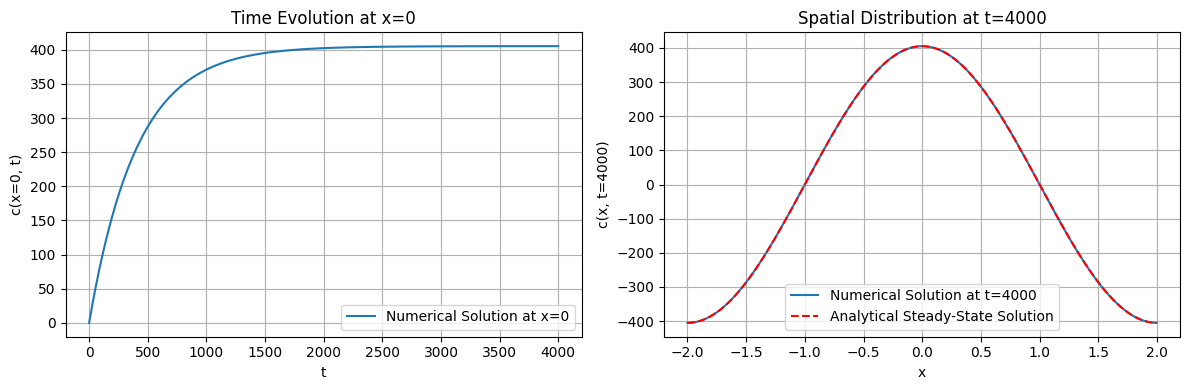

In [9]:
#@title #Plot
# Set some parameters for the problem to be solved
Nx = 1024 # The number of gridpoints. Note that Fourier transforms are more efficient if this is a power of 2
Lx = 2; # The domain size in x.  This should be large enough so that the solution goes to zero at the endpoints.
x_start=-Lx; x_end=Lx # The starting and ending bounds on x
kappa = 0.001 # set the diffusivity

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)

# Set initial conditions
c = dist.Field(name='c', bases=x_basis)
w = 0.1 # Set the width of the initial Gaussian
c.change_scales(1) # Set values on regular grid
c['g'] = np.exp(-x**2/w**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord) # Define the derivative (d/dx) operator

# Create an operator that applies a function to the variable on a grid
f_x = dist.Field(bases=x_basis)
f_x['g'] = np.cos(np.pi * x / Lx)

# Specify the problem
problem = dedalus.IVP([c], namespace=locals()) # Initial value problem, including all local variables
problem.add_equation("dt(c) - kappa * dx(dx(c)) = f_x"); # Write out the equation to be solved

timestepper = dedalus.CNAB1
solver = problem.build_solver(timestepper)

solver.stop_sim_time = 4000 # Stop at 10 simulation time units

# Main loop
timestep = 0.1
c.change_scales(1)
c_save = [np.copy(c['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
while solver.proceed:
    solver.step(timestep)
    if solver.iteration % 500 == 0: # Every 500 timesteps, print a message to the screen with the progress
        logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
    c.change_scales(1)
    c_save.append(np.copy(c['g']))
    t_save.append(solver.sim_time)

c_at_x0_snapshot = [c_snapshot[0] for c_snapshot in c_save]
c_at_x0 = np.abs(c_at_x0_snapshot)
# Extract the last time step solution (t = 4000)
c_at_t_final = c_save[-1]  # The last snapshot of c corresponds to t = 4000

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Solution
c_s = (Lx**2) / (kappa * np.pi**2) * np.cos(np.pi * x / Lx)

# Plot 1: c(x=0, t) vs t
axes[0].plot(t_save, c_at_x0, label="Numerical Solution at x=0")
axes[0].set_xlabel("t")
axes[0].set_ylabel("c(x=0, t)")
axes[0].set_title("Time Evolution at x=0")
axes[0].grid(True)
axes[0].legend()

# Plot 2: c(x, t=4000) vs x
axes[1].plot(x, c_at_t_final, label="Numerical Solution at t=4000")
axes[1].plot(x, c_s, label="Analytical Steady-State Solution", linestyle='--', color='red')  # Analytical solution
axes[1].set_xlabel("x")
axes[1].set_xlabel("x")
axes[1].set_ylabel("c(x, t=4000)")
axes[1].set_title("Spatial Distribution at t=4000")
axes[1].grid(True)
axes[1].legend()

# Adjust layout and show the figure
plt.tight_layout()
plt.show()


### 5.2 Variable diffusivity

In some applications of the diffusion equation, the diffusivity varies in space. This happens, for example, in the movement of pollution in groundwater flowing through soil of variable porosity, or the mixing of tracers due to turbulence in the ocean (which we will explore in detail in Project 2).

In the code cell below, write a Dedalus script that solves the following equation:

$$\partial_t c - \partial_x(\kappa (x) \partial_x c) = 0$$

where

$$\kappa(x)=\kappa_0(0.1 + tanh(x/0.1)+1)/2$$

and $\kappa_0=0.001$. It is fine to start by copying the code in the previous cell and changing the problem equation appropriately.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


2024-12-27 07:13:07,245 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s


INFO:solvers:Simulation stop time reached.


2024-12-27 07:13:07,853 solvers 0/1 INFO :: Simulation stop time reached.


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


2024-12-27 07:13:08,358 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s


INFO:solvers:Simulation stop time reached.


2024-12-27 07:13:08,775 solvers 0/1 INFO :: Simulation stop time reached.


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 2.9e-01/s


2024-12-27 07:13:12,213 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 3s, Remaining: 0s, Rate: 2.9e-01/s


INFO:solvers:Simulation stop time reached.


2024-12-27 07:13:12,797 solvers 0/1 INFO :: Simulation stop time reached.


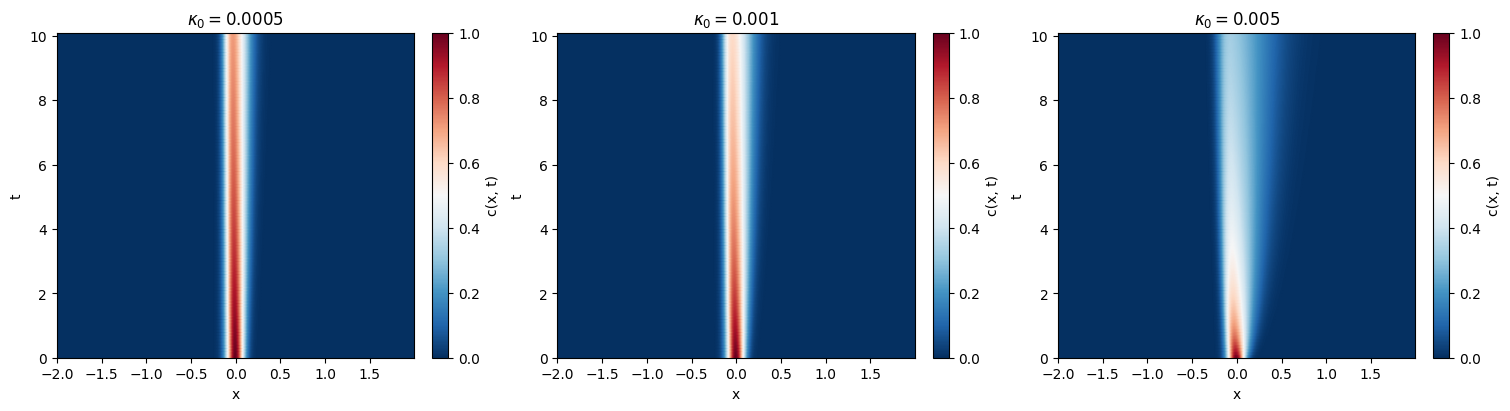

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Parameters
Nx = 1024  # Number of gridpoints
Lx = 2     # Domain size
x_start, x_end = -Lx, Lx  # Domain boundaries
kappa0_values = [0.0005, 0.001, 0.005]  # Different values of kappa0 to compare

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64)  # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(x_start, x_end))
x = dist.local_grid(x_basis)  # Grid in physical space

# Create subplots for horizontal arrangement
fig, axes = plt.subplots(1, len(kappa0_values), figsize=(15, 4), constrained_layout=True)

# Loop over kappa0 values
for i, kappa0 in enumerate(kappa0_values):
    # Field setup
    c = dist.Field(name='c', bases=x_basis)
    kappa = dist.Field(bases=x_basis)

    # Define spatially varying kappa
    kappa['g'] = kappa0 * (0.1 + np.tanh(x / 0.1) + 1) / 2

    # Set initial condition
    w = 0.1  # Width of the initial Gaussian
    c.change_scales(1)
    c['g'] = np.exp(-x**2 / w**2)

    # Define operators
    dx = lambda a: dedalus.Differentiate(a, xcoord)  # Define the derivative (d/dx) operator

    # Specify the problem
    problem = dedalus.IVP([c], namespace=locals())
    problem.add_equation("dt(c) - dx(kappa * dx(c)) = 0")  # Diffusion equation

    # Solver setup
    timestepper = dedalus.CNAB1
    solver = problem.build_solver(timestepper)

    # Stop conditions
    solver.stop_sim_time = 10  # Stop at 10 simulation time units

    # Main loop
    timestep = 0.1
    c.change_scales(1)
    c_save = [np.copy(c['g'])]  # Save initial condition
    t_save = [solver.sim_time]

    while solver.proceed:
        solver.step(timestep)
        if solver.iteration % 500 == 0:  # Log every 500 iterations
            logger.info('Iteration=%i, Time=%e, dt=%e' % (solver.iteration, solver.sim_time, timestep))
        c.change_scales(1)
        c_save.append(np.copy(c['g']))
        t_save.append(solver.sim_time)

    # Convert results to arrays for plotting
    c_save = np.array(c_save)
    t_save = np.array(t_save)

    # Plot results for this kappa0 on the corresponding axis
    ax = axes[i]
    pcm = ax.pcolormesh(x.ravel(), t_save, c_save, cmap='RdBu_r', shading='gouraud')
    fig.colorbar(pcm, ax=ax, label='c(x, t)')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_title(f'$\kappa_0 = {kappa0}$')

# Show the final horizontal plot
plt.show()



Explore the behaviour of the solution as you vary the parameters associated with $\kappa(x)$. Comment on your observations below (~1 paragraph)

**Comment:**

From the observed behavior of the solution, as $ \kappa_0 $ increases, the asymmetry in diffusion becomes more pronounced. On the right side ($ x > 0 $), where $ \kappa(x) $ is higher, the smoothing occurs faster, leading to quicker flattening of the concentration distribution. Meanwhile, on the left side ($ x < 0 $), where $ \kappa(x) $ is lower, the diffusion is slower, resulting in a higher concentration peak on that side. The shift of the concentration peak to the left is a direct consequence of this imbalance. The spatial variation of $ \kappa(x) $ is governed by the $ \tanh(x/0.1) $ function, which transitions smoothly from $ -1 $ (for $ x \to -\infty $) to $ 1 $ (for $ x \to \infty $),and increases sharply around $ x = 0 $. Because $ \kappa(x) $ follows the same directionality as $ \tanh(x/0.1) $, regions with higher diffusivity (right side) experience faster smoothing, reducing gradients more quickly. The increase in $ \kappa_0 $ amplifies this asymmetry, causing faster smoothing on the right and slower diffusion on the left.

## 6. Optional further investigations

* Try writing a Dedalus script to solve the 2D diffusion equation as an initial value problem.  You can look ahead to the the example at the end of the Project 2 notebook for some guidance (but remove the advection term). I would suggest using a Fourier/Fourier basis for this.

* Consider how you might go about discretizing a 2D diffusion equation using finite differences.  What form would the matrix M have?
